**What is langGraph**

Langgraph provides low-level supporting infrastructure that sits underneath any agent or workflow.

**Benefits**

-Control: Make it easy to define and /combine agents and workflows.

-Persistence: Provide a way to persist the state of a graph, this enbles both memory and human-in-the-loop.

-Testing, debugging and deployment: easy application of the three

In [3]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

#load environment variables
load_dotenv()


api_key=os.getenv("GITHUB_TOKEN")

llm=ChatOpenAI(
    model="gpt-4o",
    openai_api_key=api_key,
    base_url="https://models.inference.ai.azure.com"
)



In [4]:
from langchain.tools import tool

@tool
def write_email(to: str, subject:str, content:str)->str:
    """Write and send an email"""
    #placeholder response in real app would send email
    return f"Email Sent to {to} with subject '{subject}' and content: {content}"

In [5]:
#connect tools to a chat model
model_with_tools=llm.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)


#The model will now be able to call tools
output=model_with_tools.invoke("Draft a response to my boss ('boss@company.ai') about tomorrow's meeting")

a. Control

Langgraph lets us to define our application as a graph with

1. State: What information do we need to track over the course of the application?

2. Nodes: How do we want to update this information over the course of the application?

3. Edges: How do we want to connect this nodes together?

State: defines the schema for information we want to track over the course of the application.

Can be:

-TypeDict is fastest but doesnt support defaults.

-Dataclass is basically as fast, supports dot syntac state.foo and has defaults.

-Pydantic is slower(especially with custom validators)but gives type validation.



In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str


workflow=StateGraph(StateSchema)


Each node is simply a python function. This gives us full controll over the logic inside each node.

They receive the current state, return a dictionary to update the state.

**N/B**: By default state keys are overwritten.

In [5]:
#write the node
def write_email_node(state: StateSchema)-> StateSchema:
    #process the request
    output=model_with_tools.invoke(state["request"])
    args=output.tool_calls[0]['args']
    email=write_email.invoke(args)
    return {"email":email}

**Edges**: Connect nodes together.

We specify the control flow by adding edges and nodes to our state graph.

In [6]:
workflow=StateGraph(StateSchema)

#add our node
workflow.add_node("write_email_node", write_email_node)

#start our program
workflow.add_edge(START, "write_email_node")

#endd program
workflow.add_edge("write_email_node", END)

app=workflow.compile()

In [7]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email Sent to boss@company.ai with subject 'Response to Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the meeting reminder. I confirm my attendance for tomorrow. Please let me know if there’s any preparation or specific materials needed ahead of time.\n\nLooking forward to our discussion.\n\nBest regards,\n[Your Name]"}

Routing between nodes can be done conditionally using a simple Function.



In [9]:
from typing import Literal
from langgraph.graph import StateGraph, END, START, MessagesState

# Assuming model_with_tools and write_email are defined elsewhere

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""
    output = model_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [output]}

def run_tool(state: MessagesState) -> MessagesState:
    """Performs the tool call"""
    last_message = state["messages"][-1]
    results = []

    for tool_call in last_message.tool_calls:
        observation = write_email.invoke(tool_call["args"])
        results.append({
            "role": "tool",
            "content": observation,
            "tool_call_id": tool_call["id"]
        })

    return {"messages": state["messages"] + results}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if no tool call"""
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "run_tool"

    return "__end__"

# Define the workflow
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)

# Add edges
workflow.set_entry_point("call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {
    "run_tool": "run_tool",
    "__end__": END
})
workflow.add_edge("run_tool", END)

# Compile the workflow
app = workflow.compile()


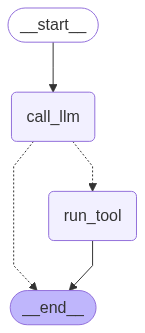

In [10]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_V7PeJiud5W82u49dDQOAquq1)
 Call ID: call_V7PeJiud5W82u49dDQOAquq1
  Args:
    to: boss@company.ai
    subject: Confirmation to Attend Interrupt
    content: Dear [Boss's Name],

Thank you for the opportunity to attend Interrupt! I’m writing to confirm my interest and availability to participate in the event. I’m really looking forward to the learnings and networking opportunities it will offer.

Please let me know if there are any additional steps I need to take or preparations I should make ahead of the event.

Thank you again for including me in this.

Best regards,
[Your Name]
================================= Tool Message =================================

Email Sent to boss@company.ai with subject 'Co

Because Agents are such a common pattern, LangGraph has a prebuilt agent abstraction.

**Langgraph Prebuilt**: pass in the LLM, tools and prompt

In [12]:
from langgraph.prebuilt import create_react_agent

agent=create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
)



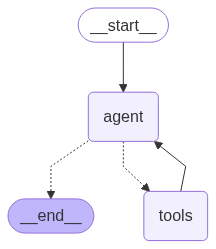

In [14]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
#runt he agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_nERq2SvuS7RE9VRXQDEtO0gE)
 Call ID: call_nERq2SvuS7RE9VRXQDEtO0gE
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt
    content: Dear [Boss's Name],

Thank you for the opportunity to attend Interrupt! I am excited to confirm my attendance and look forward to gaining valuable insights and contributing to our team’s success through this event.

Please let me know if there are any additional details or preparations required on my end.

Best regards,
[Your Name]
================================= Tool Message =================================
Name: write_email

Email Sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt' and content: Dear [Boss's Name],

Th

**Persistence**

**Threads**

Its very useful to allow agents to pause during long tasks.

Langgraph has a built in layers, implemented through checkpointers to enable this.

When we compile the graph it saves a checkpoint of the graph state at every step.

Checkpoints are saved to a thread, which can be accessed after graph execution completes.



In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

agent=create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config={"configurable":{"thread_id":"1"}}
result=agent.invoke({"messages":[{"role":"user", "content":"What are four good practices for writing emails?"}]}, config)


In [19]:
#get the latest state snapshot
config={"configurable":{"thread_id":"1"}}
state=agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are four good practices for writing emails?
================================== Ai Message ==================================

Here are four good practices for writing effective emails:

1. **Use a Clear and Concise Subject Line**:
   - Ensure the subject line reflects the content of the email. This helps the recipient understand the intent of the email at a glance and prioritize it accordingly.

2. **Maintain a Professional Tone and Structure**:
   - Start with a polite greeting.
   - Use clear, simple language and break your content into short paragraphs.
   - End with an appropriate closing and include your contact information (if needed).

3. **Be Purposeful and Respectful of Time**:
   - Get to the point quickly without unnecessary details. This shows respect for your recipient's time.
   - Include only the information or questions necessary for the purpose of your email.

4. **Proofread Before S

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent

agent=create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to user's request using the tools provided.",
    checkpointer=InMemorySaver()
)


config = {"configurable": {"thread_id": "2"}}

while True:
    user = input("You>> ")
    if user.lower() in ["quit", "exit"]:
        break

    result = agent.invoke({
        "messages": [HumanMessage(content=user)]
    }, config)

    # Print assistant messages
    for msg in result["messages"]:
        if msg.type == "ai":  # or isinstance(msg, AIMessage)
            print("AI:", msg.content)


AI: How can I assist you today?
AI: How can I assist you today?
AI: It seems you haven't provided any input or request. How can I help you today?
AI: How can I assist you today?
AI: It seems you haven't provided any input or request. How can I help you today?
AI: Hi there! How can I assist you today? 😊
AI: How can I assist you today?
AI: It seems you haven't provided any input or request. How can I help you today?
AI: Hi there! How can I assist you today? 😊
AI: It seems like you didn't include any message. Let me know how I can help you! 😊
AI: How can I assist you today?
AI: It seems you haven't provided any input or request. How can I help you today?
AI: Hi there! How can I assist you today? 😊
AI: It seems like you didn't include any message. Let me know how I can help you! 😊
AI: Hi again! Let me know if there's anything I can do for you. 😊
AI: How can I assist you today?
AI: It seems you haven't provided any input or request. How can I help you today?
AI: Hi there! How can I assist y